In [126]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/rupertmenneer/Documents/git/bayesian_flow/')
from discretised.bfn_discretised_data import DiscretisedBimodalData
from discretised.bfn_discretised import BayesianFlowNetworkDiscretised
from bfn.models import SimpleNeuralNetworkDiscretised
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, AdamW
import matplotlib.pyplot as plt
import torch
torch.set_printoptions(precision=5, sci_mode=False)
k = 5
dataset = DiscretisedBimodalData(n=1000, k=k)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)
batch = next(iter(dataloader))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([256, 1])


(array([10., 76., 66., 82., 22.]),
 array([-0.80000001, -0.48000002, -0.16000003,  0.15999997,  0.47999996,
         0.79999995]),
 <BarContainer object of 5 artists>)

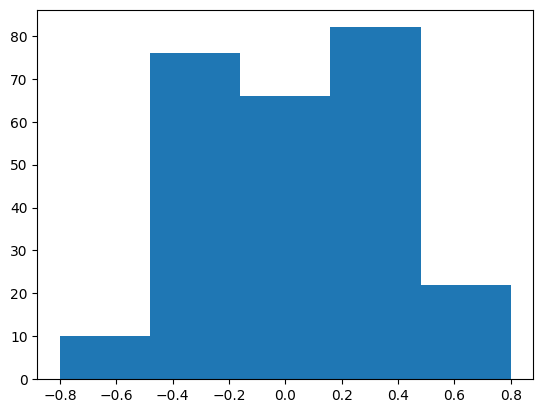

In [127]:
bs=256
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
batch = next(iter(dataloader))
print(batch.shape)
plt.hist(batch.squeeze(), bins=k)

In [120]:
from torch_ema import ExponentialMovingAverage

device = 'cpu'
bfn_model = BayesianFlowNetworkDiscretised(SimpleNeuralNetworkDiscretised(), device=device, k=k).to(device)
optim = AdamW(bfn_model.parameters(), lr=3e-4, betas=(0.9, 0.98), weight_decay=0.01)

ema = ExponentialMovingAverage(bfn_model.parameters(), decay=0.995)
torch.autograd.set_detect_anomaly(True)
epochs = 1000
losses = []
n_batches_track = 100
for i in range(epochs):
    # print(i)
    epoch_losses = []
    for _, batch in enumerate(dataloader):
        optim.zero_grad()
        loss = bfn_model.continuous_time_loss_for_discretised_data(batch.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bfn_model.parameters(), max_norm=2.0)
        optim.step()
        # Update the moving average with the new parameters from the last optimizer step
        ema.update()
        epoch_losses.append(loss.item())
    if i%n_batches_track == 0:
        print(f'Epoch {i+1}/{epochs}, Loss: {torch.mean(torch.tensor(epoch_losses))}')
    losses.append(torch.mean(torch.tensor(epoch_losses)))



Epoch 1/1000, Loss: 3.185670852661133
Epoch 101/1000, Loss: 2.7311038970947266
Epoch 201/1000, Loss: 2.7597391605377197
Epoch 301/1000, Loss: 2.676849365234375


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training loss')

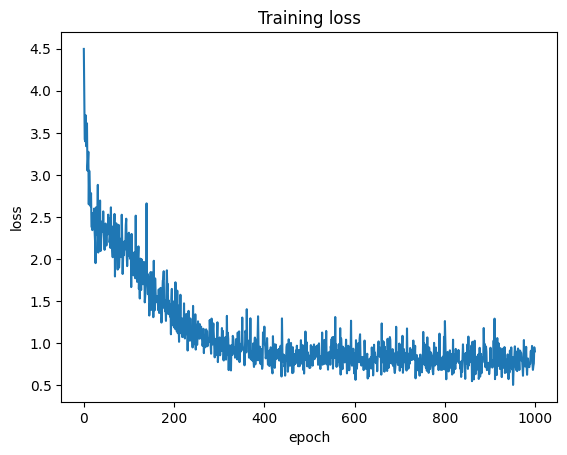

In [113]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')

# Sample generation

In [114]:
k=5
bs=1000
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
batch = next(iter(dataloader))
print(len(torch.unique(batch)))
samples, priors = bfn_model.sample_generation_for_discretised_data(n_steps=10, bs=bs)
samples = samples.to(torch.float32)
print(len(torch.unique(samples)))

2
5


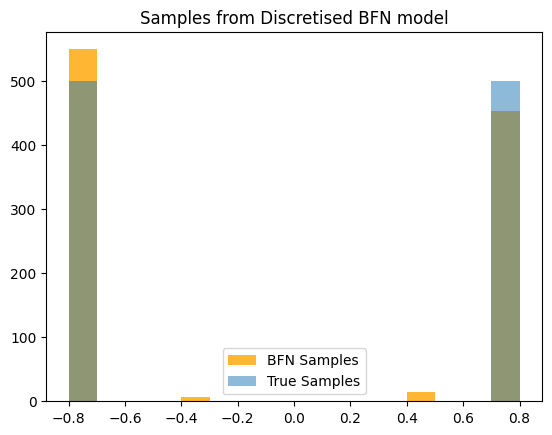

In [119]:
k=5
bs=1024
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
batch = next(iter(dataloader))
batch.shape
with ema.average_parameters():
    samples, priors = bfn_model.sample_generation_for_discretised_data(n_steps=25, bs=bs)
    samples = samples.to(torch.float32)

k=16
plt.hist(samples.detach().numpy(), alpha=0.8, bins=k, label='BFN Samples', color='orange')
plt.hist(batch.numpy(), bins=k, alpha=0.5, label='True Samples')
plt.title('Samples from Discretised BFN model')
plt.legend()

In [ ]:
# priors

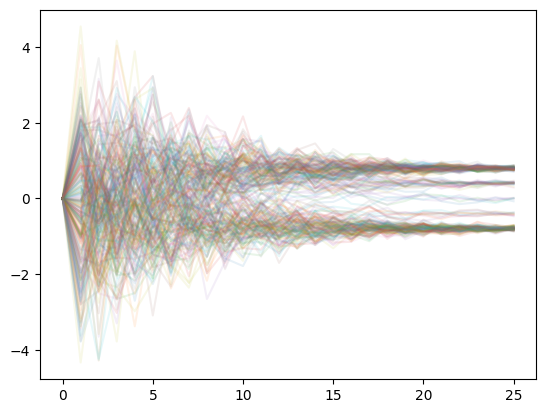

In [107]:
plt.plot(priors.detach().numpy()[:256, :, 0, :].squeeze().T, label='Prior mu', alpha=0.1);
# plt.plot(priors.detach().numpy()[0, :, 1, :].squeeze(), label='Prior precision')

In [ ]:

from bfn_github.bfn import BayesianFlowNetwork
import torch
# network should learn:
# when x0 = 0, x1 = 1
# when x0 = 1, x1 = 0
def get_datapoint(batch=128, device='cpu'):
    x0 = torch.randint(0, 2, size=(batch,), dtype=torch.bool, device=device)
    x1 = ~x0

    X = torch.stack([x0, x1], dim=0)
    return X.long().transpose(0, 1)

X = get_datapoint()  # (B, D=2) with K=2 classes 
print(X.shape)
# plt.title("Dataset")
# plt.scatter(X[:, 0], X[:, 1]);
# plt.grid()

from torch.optim import AdamW
from tqdm.auto import tqdm

bfn = BayesianFlowNetwork()

optim = AdamW(bfn.parameters(), lr=1e-2)


n = 1000
losses = []
for i in tqdm(range(n)):
    optim.zero_grad()
    X = get_datapoint(device='cpu')
    loss = bfn.process(X)
    loss.backward()
    optim.step()
    losses.append(loss.item())

bfn.sample(16)

In [ ]:
torch.nn.functional.one_hot(torch.tensor([2, 1]).unsqueeze(0), num_classes=3)
def vectorised_discretised_cdf(mu, sigma, bounds):
    # input is mu, sigma -> B x D, and bounds -> K
    lower_mask = bounds < -1
    upper_mask = bounds > 1

    # output is B x D x K
    result = torch.zeros(mu.shape[0], mu.shape[1], bounds.shape[0])
    result = 0.5 * (1 + torch.erf((bounds - mu.unsqueeze(-1)) / (sigma.unsqueeze(-1) * torch.sqrt(torch.tensor(2.0)))))
    # clip result depending on boundsa
    result[:, :, lower_mask] = 0
    result[:, :, upper_mask] = 1

    return result

mu = torch.randn(2, 2)
sigma = torch.ones(2, 2)
bounds = torch.linspace(-1.1, 1.1, 4)

cdf = vectorised_discretised_cdf(mu, sigma, bounds)

print(cdf)